In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Call this function before creating and training your model
set_seeds(42)

In [4]:
# CONSTANT
LEARNING_RATE_VAL = 0.0001
BATCH_SIZE = 512
VALIDATION_SPLIT_VAL = 0.2
EPOCH_NUMBER = 50

In [5]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=1,              # Number of epochs to wait for improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

### load dataset

In [6]:
def load_np_array(file_name):
    X_array = np.load('data/X_' + file_name + '_array.npy')
    y_array = np.load('data/y_' + file_name + '_array.npy')
    return X_array, y_array

X_train_fall, y_train_fall = load_np_array("train_fall")
X_train_notfall, y_train_notfall = load_np_array("train_notfall")
X_test_fall, y_test_fall = load_np_array("test_fall")
X_test_notfall, y_test_notfall = load_np_array("test_notfall")

# Combine fall and non-fall data for training
X_train = np.concatenate((X_train_fall, X_train_notfall), axis=0)
y_train = np.concatenate((y_train_fall, y_train_notfall), axis=0)

# Combine fall and non-fall data for testing
X_test = np.concatenate((X_test_fall, X_test_notfall), axis=0)
y_test = np.concatenate((y_test_fall, y_test_notfall), axis=0)

# Shuffle the training data
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Shuffle the testing data
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print("Combined training data shape:", X_train.shape, y_train.shape)
print("Combined testing data shape:", X_test.shape, y_test.shape)

Combined training data shape: (5824, 40, 3) (5824,)
Combined testing data shape: (2912, 40, 3) (2912,)


In [7]:
class TFTModel(tf.keras.Model):
    def __init__(self, input_shape, num_features, num_heads, num_units):
        super(TFTModel, self).__init__()
        # GRU Layer
        self.gru = layers.GRU(num_units, return_sequences=True, input_shape=input_shape)
        # Multi-Head Attention Layer
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_units)
        # Gated Mechanism
        self.gate = layers.Dense(num_units, activation='sigmoid')
        # Dense Layers
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout_dense1 = layers.Dropout(0.5)
        # Output Layer
        self.output_layer = layers.Dense(1, activation='sigmoid')  # Binary classification

    def call(self, inputs, training=False):
        # GRU layer
        x = self.gru(inputs)
        # Attention layer
        attn_output = self.attention(x, x)
        # Gated residual connections
        gated_output = self.gate(attn_output) * attn_output
        # Dense Layers
        x = tf.reduce_mean(gated_output, axis=1)  # Global average pooling
        x = self.dense1(x)
        x = self.dropout_dense1(x, training=training)
        # Output layer
        return self.output_layer(x)

# Define model parameters
input_shape = (X_train.shape[1], X_train.shape[2]) # (40, 3)
num_features = X_train.shape[2]
num_heads = 4
num_units = 256  # Number of GRU units

# Instantiate and compile the model
model = TFTModel(input_shape=input_shape, num_features=num_features, num_heads=num_heads, num_units=num_units)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_VAL), loss='binary_crossentropy', metrics=['accuracy'])

2024-08-03 03:43:53.733554: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-03 03:43:53.733574: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-03 03:43:53.733579: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-03 03:43:53.733593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-03 03:43:53.733603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Se

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=EPOCH_NUMBER, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT_VAL, callbacks=[early_stopping])#, callbacks=[early_stopping])

Epoch 1/50


2024-08-03 03:43:54.611693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.5969 - loss: 0.6917 - val_accuracy: 0.6567 - val_loss: 0.6849
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step - accuracy: 0.6289 - loss: 0.6831 - val_accuracy: 0.6378 - val_loss: 0.6704
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.6304 - loss: 0.6686 - val_accuracy: 0.6524 - val_loss: 0.6471
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step - accuracy: 0.6456 - loss: 0.6467 - val_accuracy: 0.6712 - val_loss: 0.6200
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.6624 - loss: 0.6249 - val_accuracy: 0.6738 - val_loss: 0.5961
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - accuracy: 0.6786 - loss: 0.6072 - val_accuracy: 0.6781 - val_loss: 0.5775
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 481ms/step - accuracy: 0.7014 - loss: 0.5898 - val_accuracy: 0.7004 - val_loss: 0.5622
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 513ms/step - accuracy: 0.7100 - loss: 0.5765 - val_accuracy: 0.7236 - val_

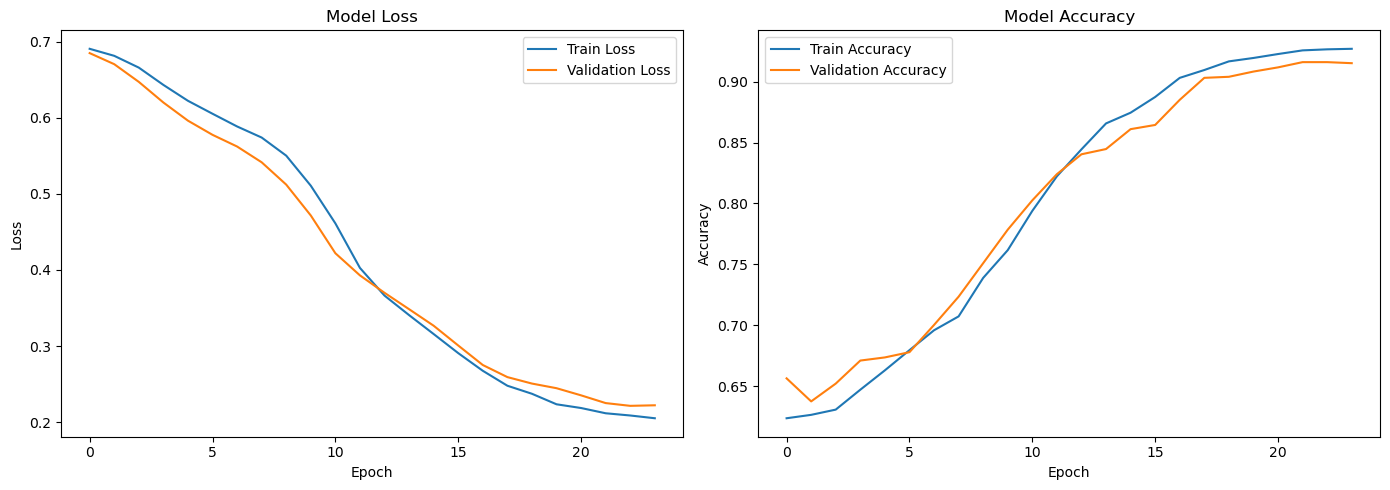

In [9]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
# Generate predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Not Fall', 'Fall']))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9354
Precision: 0.9232
Recall: 0.9499
F1 Score: 0.9364

Classification Report:
               precision    recall  f1-score   support

    Not Fall       0.95      0.92      0.93      1456
        Fall       0.92      0.95      0.94      1456

    accuracy                           0.94      2912
   macro avg       0.94      0.94      0.94      2912
weighted avg       0.94      0.94      0.94      2912



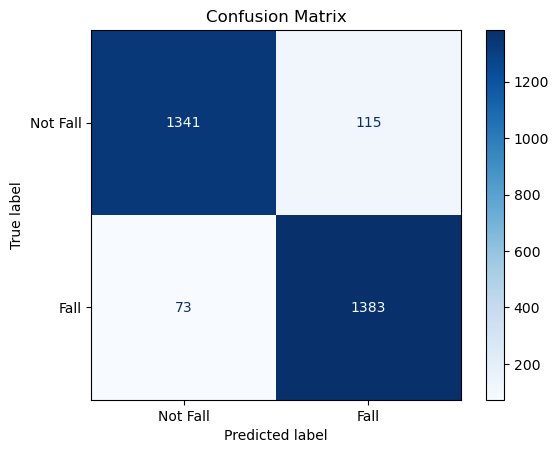

In [11]:
# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fall', 'Fall'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

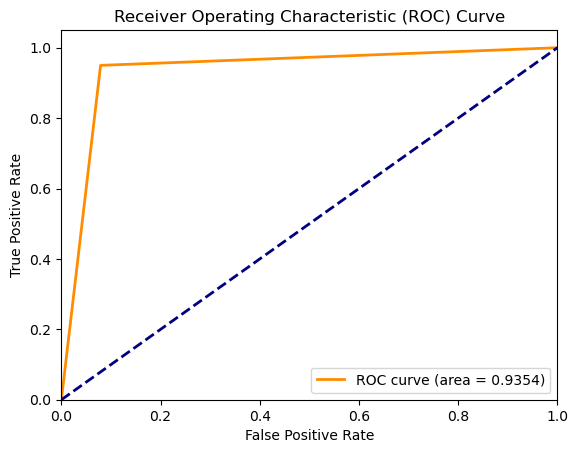

In [12]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()